In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('sb_30-05_slim_slim-1.csv')

In [3]:
sb_labs = df['shot_statsbomb_xg'].values
y = df['goal'].values

print(f"sb_labs shape: {sb_labs.shape}, y shape: {y.shape}")

sb_labs shape: (77617,), y shape: (77617,)


In [4]:
df['header'] = df['shot_body_part'] == 'Head'
df['header'] = df['header'].astype(int)
df['shot_aerial_won'] = df['shot_aerial_won'].astype(int)
df['shot_first_time'] = df['shot_first_time'].astype(int)
df['shot_one_on_one'] = df['shot_one_on_one'].astype(int)
df['under_pressure'] = df['under_pressure'].astype(int)

In [5]:
df.drop(['shot_body_part', 'shot_technique', 'shot_outcome', 'goal', 'shot_statsbomb_xg'], axis = 1, inplace = True)

In [6]:
df_1h = pd.get_dummies(df, columns = ['play_pattern', 'shot_type', 'prev_type'])

In [7]:
useful_cols = [0,4,1,3,2,15,30,18,29,17,20,9,28,5,7,27,25,24,26,8,21,13,12,6,23,10,16,11,
              -1,14,19]

use_cols = [col + 1 for col in useful_cols]
#use_cols

In [8]:
df_slim = df_1h.copy()
df_slim = df_slim.iloc[:, use_cols]

In [9]:
print(list(df_1h.columns))

['x', 'y', 'goalkeeper_dx', 'goalkeeper_dy', 'opposition_1_dx', 'opposition_1_dy', 'opposition_2_dx', 'opposition_2_dy', 'opposition_3_dx', 'opposition_3_dy', 'opposition_4_dx', 'opposition_4_dy', 'teammate_1_dx', 'teammate_1_dy', 'teammate_2_dx', 'teammate_2_dy', 'goalkeeper_x', 'goalkeeper_y', 'opposition_1_x', 'opposition_1_y', 'opposition_2_x', 'opposition_2_y', 'opposition_3_x', 'opposition_3_y', 'opposition_4_x', 'opposition_4_y', 'teammate_1_x', 'teammate_1_y', 'teammate_2_x', 'teammate_2_y', 'shot_aerial_won', 'shot_first_time', 'shot_one_on_one', 'under_pressure', 'prev_x', 'prev_y', 'header', 'play_pattern_From Corner', 'play_pattern_From Counter', 'play_pattern_From Free Kick', 'play_pattern_From Goal Kick', 'play_pattern_From Keeper', 'play_pattern_From Kick Off', 'play_pattern_From Throw In', 'play_pattern_Other', 'play_pattern_Regular Play', 'shot_type_Corner', 'shot_type_Free Kick', 'shot_type_Open Play', 'prev_type_50/50', 'prev_type_Ball Recovery', 'prev_type_Block', '

In [10]:
df_opp = df_1h.copy()

df_opp = df_opp[['opposition_1_x', 'opposition_1_y', 'opposition_2_x', 'opposition_2_y', 'opposition_3_x', 'opposition_3_y', 'opposition_4_x', 'opposition_4_y',]]

df_opp.head()

,opposition_1_x,opposition_1_y,opposition_2_x,opposition_2_y,opposition_3_x,opposition_3_y,opposition_4_x,opposition_4_y
0,101.9,35.1,105.4,31.5,107.2,38.1,105.5,28.3
1,114.3,34.6,113.0,37.1,114.6,39.1,109.3,48.1
2,108.9,59.7,109.1,50.8,108.9,46.2,113.3,46.9
3,114.1,46.4,113.2,46.6,113.0,45.1,113.4,41.2
4,91.9,43.8,92.3,40.6,91.1,51.5,102.0,41.4


In [11]:
import numpy as np

def shuffle_positions(row, prefixes, counts):
    result = row.to_dict()
    for prefix, count in zip(prefixes, counts):
        if prefix[-1] == 'd':
            positions = [
                (row[f'{prefix[:-1]}{i}_{prefix[-1]}x'], row[f'{prefix[:-1]}{i}_{prefix[-1]}y'])
                for i in range(1, count + 1)
            ]
        else:
            positions = [
                (row[f'{prefix}_{i}_x'], row[f'{prefix}_{i}_y'])
                for i in range(1, count + 1)
            ]
        np.random.shuffle(positions)
        for i in range(1, count + 1):
            if prefix[-1] == 'd':
                result[f'{prefix[:-1]}{i}_{prefix[-1]}x'] = positions[i-1][0]
                result[f'{prefix[:-1]}{i}_{prefix[-1]}y'] = positions[i-1][1]
            else:
                result[f'{prefix}_{i}_x'] = positions[i-1][0]
                result[f'{prefix}_{i}_y'] = positions[i-1][1]
    return pd.Series(result)

prefixes = ['opposition', 'opposition_d', 'teammate', 'teammate_d']
counts = [4, 4, 2, 2]

shuffled_df = df_1h.apply(shuffle_positions, axis=1, prefixes=prefixes, counts=counts)

shuffled_df.head()

KeyboardInterrupt: 

In [ ]:
df_1h.head()

In [ ]:
shuffled_df.columns

In [ ]:
len(shuffled_slim.columns)

In [ ]:
shuffled_slim = shuffled_df.copy()
num_cols = np.arange(0,32,1)
shuffled_slim = shuffled_slim.iloc[:, num_cols]
shuffled_slim.head()

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, sb_train, sb_test = train_test_split(
    df_1h, y, sb_labs, random_state=42)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

import numpy as np

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)

In [11]:
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import KFold
space = {
    'hidden_size': hp.choice('hidden_size', [100, 200, 300, 400, 500]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
    'batch_size': hp.choice('batch_size', [50, 100, 200]),
}

def objective(params):
    # Initialize the model with the given hyperparameters
    hidden_size = int(params['hidden_size'])
    learning_rate = params['learning_rate']
    batch_size = int(params['batch_size'])

    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in kfold.split(X_train_tensor):
        X_train_fold, X_val_fold = X_train_tensor[train_idx], X_train_tensor[val_idx]
        y_train_fold, y_val_fold = y_train_tensor[train_idx], y_train_tensor[val_idx]

        train_dataset = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
        val_dataset = torch.utils.data.TensorDataset(X_val_fold, y_val_fold)

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

        model = nn.Sequential(
            nn.Linear(X_train.shape[1], hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.BCELoss()

        # Train the model
        num_epochs = 4
        for epoch in range(num_epochs):
            model.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                output = model(data).squeeze()
                loss = criterion(output, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Evaluate the model
        model.eval()
        y_true = []
        y_scores = []
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data).squeeze()
                y_true.extend(target.cpu().numpy())
                y_scores.extend(output.cpu().numpy())

        auc = roc_auc_score(y_true, y_scores)
        auc_scores.append(auc)

    mean_auc = np.mean(auc_scores)
    print(f'Cross-Validation ROC AUC: {mean_auc:.4f}')

    # Return the negative mean ROC AUC as Hyperopt minimizes the objective function
    return {'loss': -mean_auc, 'status': STATUS_OK}


In [12]:
# Run hyperparameter optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print('Best hyperparameters:', best)

Cross-Validation ROC AUC: 0.7864                                                                                   
Cross-Validation ROC AUC: 0.7874                                                                                   
Cross-Validation ROC AUC: 0.7833                                                                                   
Cross-Validation ROC AUC: 0.7866                                                                                   
Cross-Validation ROC AUC: 0.7840                                                                                   
Cross-Validation ROC AUC: 0.7860                                                                                   
Cross-Validation ROC AUC: 0.7871                                                                                   
Cross-Validation ROC AUC: 0.7866                                                                                   
Cross-Validation ROC AUC: 0.7862                                        

In [14]:
input_size = X_train.shape[1]
hidden_size = 400
num_classes = 1 


model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_classes),
    nn.Sigmoid() 
).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.00023830769715027292)
criterion = nn.BCELoss()  

In [15]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data).squeeze() 
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(epoch):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            predicted = (output > 0.5).float()  # Apply threshold for binary classification
            correct += (predicted == target).sum().item()
            total += target.size(0)
    accuracy = 100 * correct / total
    print(f'Test accuracy after {epoch+1} epochs: {accuracy:.2f} %')


In [16]:
num_epochs = 4
for epoch in range(num_epochs):
    train(epoch)
    test(epoch)

# Save the trained model
torch.save(model.state_dict(), 'binary_classification_model.pth')


Test accuracy after 1 epochs: 90.72 %
Test accuracy after 2 epochs: 90.66 %
Test accuracy after 3 epochs: 90.84 %
Test accuracy after 4 epochs: 90.85 %


In [17]:
model.eval()
with torch.no_grad():
    output = model(X_test_tensor.to(device)).squeeze()
    y_pred_probs = output.cpu().numpy()



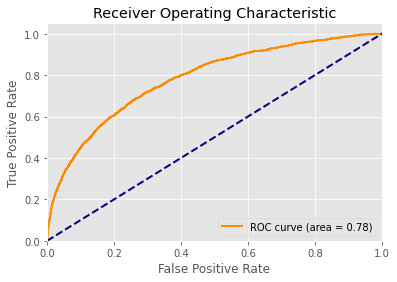

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
plt.style.use('ggplot')
y_test_conv = y_test.astype(int)
roc_auc = roc_auc_score(y_test_conv, y_pred_probs)

fpr, tpr, _ = roc_curve(y_test_conv, y_pred_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

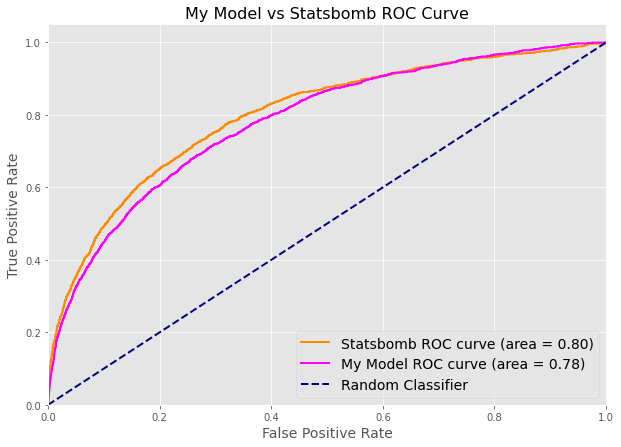

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
plt.style.use('ggplot')


roc_auc_sb = roc_auc_score(y_test_conv, sb_test)

fpr_sb, tpr_sb, _ = roc_curve(y_test_conv, sb_test)
plt.figure(figsize = (10,7))
plt.plot(fpr_sb, tpr_sb, color='darkorange', lw=2, label=f'Statsbomb ROC curve (area = {roc_auc_sb:.2f})')
plt.plot(fpr, tpr, color='#FF00FF', lw=2, label=f'My Model ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('My Model vs Statsbomb ROC Curve', fontsize = 16)
plt.legend(loc='lower right', fontsize = 14)
#plt.savefig('first_attempt1.png', dpi = 1000, facecolor = 'white', bbox_inches = 'tight')
plt.show()

In [20]:
from sklearn.metrics import log_loss

logloss_model = log_loss(y_test_conv, y_pred_probs)
logloss_sb = log_loss(y_test_conv, sb_test)

print(f"Model Log Loss: {logloss_model}")
print(f"Statsbomb Log Loss: {logloss_sb}")

Model Log Loss: 0.2618126838070559
Statsbomb Log Loss: 0.25385731116418275


In [21]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_test_conv, y_pred_probs)
roc_auc_sb = roc_auc_score(y_test_conv, sb_test)
print(f"My model: {roc_auc}")
print(f"SB: {roc_auc_sb}")

My model: 0.7827543753019466
SB: 0.7993221281967366
